# Import &  Data exploration

## import de librairie 

In [1]:
import tensorflow as tf  

import pathlib 
import numpy as np
import pandas as pd 
import random
from datetime import datetime
import time

import os
import io
import warnings

warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ( accuracy_score, precision_score, recall_score, f1_score,confusion_matrix,classification_report,ConfusionMatrixDisplay)

from tensorflow import keras
from keras import layers, Model, Input
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


import tensorflow.keras as k
import tensorflow_hub as hub

import keras_nlp





Using TensorFlow backend


## import DATA

In [2]:
# Import dataset with Pandas 
dataset = pd.read_csv("spam.csv",encoding='latin-1')
dataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
dataset.describe(include='all')

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [4]:
# traitement des valeurs manquantes 
print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])

Percentage of missing values: 


v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

In [5]:
dataset = dataset[['v1','v2']]

# Mapping de la colonne 'v1' où 'ham' devient 0 et 'spam' devient 1
dataset['v1'] = dataset['v1'].map({'ham': 0, 'spam': 1})
dataset = dataset.rename(columns={'v1': 'spam'})

dataset.head()


,spam,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# Preprocessing



2. import et Load `en_core_news_md` --> variable `nlp`

In [6]:
!python -m spacy download en_core_web_md

     ---------------------------------------- 0.0/33.5 MB ? eta -:--:--
     ------------------ ------------------- 16.5/33.5 MB 103.5 MB/s eta 0:00:01
     --------------------------------------  33.3/33.5 MB 88.1 MB/s eta 0:00:01
     --------------------------------------- 33.5/33.5 MB 78.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [7]:
import en_core_web_md
nlp = en_core_web_md.load()


3. Import des "english STOP_WORDS"

In [8]:
# Import Stop words 
from spacy.lang.en.stop_words import STOP_WORDS

In [9]:
# Traitement des carcteres speciaux (on ne garde que les caracteres alphanumerique et espace)
dataset["v2clean"] = dataset["v2"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))

# Traitement MAJUSCULE / MINUSCULE 
dataset["v2_clean"] = dataset["v2clean"].apply(lambda x: x.replace(" +"," ").lower().strip())

# Lemmatization 
dataset["spam_clean"] = dataset["v2_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

dataset.head()

,spam,v2,v2clean,v2_clean,spam_clean
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,go until jurong point crazy available only in ...,jurong point crazy available bugis n great wor...
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,ok lar joking wif u oni,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,u dun say so early hor u c already then say,u dun early hor u c
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I don't think he goes to usf he lives arou...,nah i don't think he goes to usf he lives arou...,nah think usf live


# TF/IDF +regression logistique

### 1. vectorisation dataset

In [10]:
# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(dataset['spam_clean'])

# X is a generator. We can transform that as an array
dense = X.toarray()
dense

# Get tokens for all documents
vectorizer.vocabulary_

tf_idf = pd.DataFrame(dense, 
             columns=vectorizer.get_feature_names_out(), 
             index=[f"doc_{x}" for x in range(1, dense.shape[0] + 1)])

print (f" la taille du corpus est de : {tf_idf.shape[0]} docs composé de {tf_idf.shape[1]} colonnes.")
tf_idf

 la taille du corpus est de : 5572 docs composé de 8094 colonnes.


,008704050406,0089my,0121,01223585236,01223585334,0125698789,02,020603,0207,02070836089,...,åð,åòharry,åòit,åômorrow,åôrent,ìï,ûthank,ûï,ûïharry,ûò
doc_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doc_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doc_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doc_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doc_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
doc_5568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doc_5569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doc_5570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doc_5571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2. ENTRAINEMENT  MODEL -->  TF/IDF + regression logistic

In [11]:
# Récupérer les features et labels
X = tf_idf
y = dataset["spam"].values

# Split train / validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Entraîner un modèle simple
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Prédictions
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)


### 3. Evaluation du model

In [12]:
# Matrice de confusion
cm_val = confusion_matrix(y_val, y_val_pred)
df_cm_val = pd.DataFrame(cm_val, index=["ham", "spam"], columns=["ham", "spam"])
df_cm_val = df_cm_val.iloc[::-1]  # ✅ inverser les lignes pour que "ham" soit en haut


# Métriques de validation
metrics_val = {
    "F1-score": round(f1_score(y_val, y_val_pred), 3),
    "Precision": round(precision_score(y_val, y_val_pred), 3),
    "Recall": round(recall_score(y_val, y_val_pred), 3),
    "Accuracy": round(accuracy_score(y_val, y_val_pred), 3)
}

# Subplots : 1 ligne × 2 colonnes
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Matrice de Confusion (Val)", "Métriques (Val)"),
    specs=[[{"type": "heatmap"}, {"type": "table"}]]
)

# Heatmap (avec "ham / ham" en haut à gauche)
fig.add_trace(go.Heatmap(
    z=df_cm_val.values,
    x=df_cm_val.columns,
    y=df_cm_val.index,
    text=df_cm_val.values,
    texttemplate="%{text}",
    colorscale='Blues',
    showscale=False
), row=1, col=1)

# Bordure noire autour de la heatmap
fig.add_shape(
    type="rect",
    x0=-0.5, x1=1.5,
    y0=-0.5, y1=1.5,
    line=dict(color="black", width=2),
    row=1, col=1
)


# Table des métriques
fig.add_trace(go.Table(
    header=dict(values=["Métrique", "Valeur"], fill_color="lightgrey"),
    cells=dict(values=[
        list(metrics_val.keys()),
        list(metrics_val.values())
    ])
), row=1, col=2)

# Titres des axes
fig.update_xaxes(title_text="Prédiction", row=1, col=1)
fig.update_yaxes(title_text="Réel", row=1, col=1)

# Mise en page
fig.update_layout(
    title_text="Évaluation Régression Logistique + TF-IDF",
    height=400, width=700
)

fig.show()



# Deep Learning MODEL

## Preprocessing

1. Encodage des commentaires

In [13]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab")

tokenizer.fit_on_texts(dataset['spam_clean'])

dataset["spam_clean_encoded"] = tokenizer.texts_to_sequences(dataset['spam_clean'])
dataset.head()

,spam,v2,v2clean,v2_clean,spam_clean,spam_clean_encoded
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,go until jurong point crazy available only in ...,jurong point crazy available bugis n great wor...,"[1, 231, 446, 463, 937, 32, 48, 206, 938, 79, ..."
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,ok lar joking wif u oni,ok lar joke wif u oni,"[8, 196, 464, 291, 2, 1]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[10, 301, 3, 532, 660, 30, 1, 842, 425, 1, 1, ..."
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,u dun say so early hor u c already then say,u dun early hor u c,"[2, 125, 149, 1, 2, 81]"
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I don't think he goes to usf he lives arou...,nah i don't think he goes to usf he lives arou...,nah think usf live,"[700, 20, 661, 130]"


8. Padding

In [14]:
spam_pad = tf.keras.preprocessing.sequence.pad_sequences(dataset.spam_clean_encoded, padding="post")
spam_pad.shape


(5572, 74)

In [15]:
dataset.to_csv('data_spam_clean.csv', index=False)

In [16]:
dataset.head()

,spam,v2,v2clean,v2_clean,spam_clean,spam_clean_encoded
0,0,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...,go until jurong point crazy available only in ...,jurong point crazy available bugis n great wor...,"[1, 231, 446, 463, 937, 32, 48, 206, 938, 79, ..."
1,0,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,ok lar joking wif u oni,ok lar joke wif u oni,"[8, 196, 464, 291, 2, 1]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[10, 301, 3, 532, 660, 30, 1, 842, 425, 1, 1, ..."
3,0,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,u dun say so early hor u c already then say,u dun early hor u c,"[2, 125, 149, 1, 2, 81]"
4,0,"Nah I don't think he goes to usf, he lives aro...",Nah I don't think he goes to usf he lives arou...,nah i don't think he goes to usf he lives arou...,nah think usf live,"[700, 20, 661, 130]"


9. Train_val_split



In [17]:
# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [18]:
# Split
X_train, X_valtest, y_train, y_valtest = train_test_split(
    spam_pad, dataset.spam, test_size=0.4, stratify=dataset['spam'], random_state=seed)

X_val, X_test, y_val, y_test = train_test_split(
    X_valtest, y_valtest, test_size=0.5, stratify=y_valtest, random_state=seed)

In [19]:
# Dataset batches with seed in shuffle
train_batch = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train), seed=seed).batch(64)
val_batch = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(len(X_val), seed=seed).batch(64)
test_batch = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(len(X_test), seed=seed).batch(64)


In [20]:
for tensor, spam in train_batch.take(1):
  print(tensor, spam)

tf.Tensor(
[[ 49  53 297 ...   0   0   0]
 [  1   1  67 ...   0   0   0]
 [  1  78 159 ...   0   0   0]
 ...
 [  1 179  42 ...   0   0   0]
 [128 511   1 ...   0   0   0]
 [  1 109  31 ...   0   0   0]], shape=(64, 74), dtype=int32) tf.Tensor(
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1], shape=(64,), dtype=int64)


##  RNN model

### 1. structure model.

In [21]:
vocab_size = tokenizer.num_words
model_rnn = tf.keras.Sequential([
                  # Couche d'Input Word Embedding           
                  tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=[tensor.shape[1],],name="embedding"),
                  
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),

                  # Couche de sortie avec fonction d'activation sigmoid
                  tf.keras.layers.Dense(1, activation="sigmoid")
])

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 74, 8)             8008      
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8,169
Trainable params: 8,169
Non-trainable params: 0
_________________________________________________________________


### 2. Model compilation with the loss function, and the Adam optimizer.

In [22]:
optimizer= tf.keras.optimizers.Adam()

In [23]:
# We compile the model_rnn
model_rnn.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [24]:
dataset['spam'].value_counts()

spam
0    4825
1     747
Name: count, dtype: int64

In [25]:
weights = 1/(dataset['spam']).value_counts()
weights = weights * len(dataset)/2
weights = {index : values for index, values in zip(weights.index, weights.values)}
weights

{0: 0.5774093264248704, 1: 3.72958500669344}

### 3. Model fitting on n epochs with weights to penalize too frequent notes. 

In [26]:
# Fit the model on epochs
history = model_rnn.fit(train_batch,
                    epochs=100,
                    validation_data=val_batch,
                    class_weight=weights
                    )

Epoch 1/100
53/53 [==============================] - 1s 3ms/step - loss: 0.6903 - accuracy: 0.8654 - val_loss: 0.6638 - val_accuracy: 0.8654
Epoch 2/100
53/53 [==============================] - 0s 1ms/step - loss: 0.6816 - accuracy: 0.8702 - val_loss: 0.6490 - val_accuracy: 0.8788
Epoch 3/100
53/53 [==============================] - 0s 2ms/step - loss: 0.6631 - accuracy: 0.8875 - val_loss: 0.6005 - val_accuracy: 0.8959
Epoch 4/100
53/53 [==============================] - 0s 1ms/step - loss: 0.6300 - accuracy: 0.9070 - val_loss: 0.5399 - val_accuracy: 0.9210
Epoch 5/100
53/53 [==============================] - 0s 1ms/step - loss: 0.5776 - accuracy: 0.9372 - val_loss: 0.4415 - val_accuracy: 0.9318
Epoch 6/100
53/53 [==============================] - 0s 2ms/step - loss: 0.5098 - accuracy: 0.9420 - val_loss: 0.3718 - val_accuracy: 0.9399
Epoch 7/100
53/53 [==============================] - 0s 1ms/step - loss: 0.4417 - accuracy: 0.9509 - val_loss: 0.3240 - val_accuracy: 0.9461
Epoch 8/100
5

### 4- Evaluation 

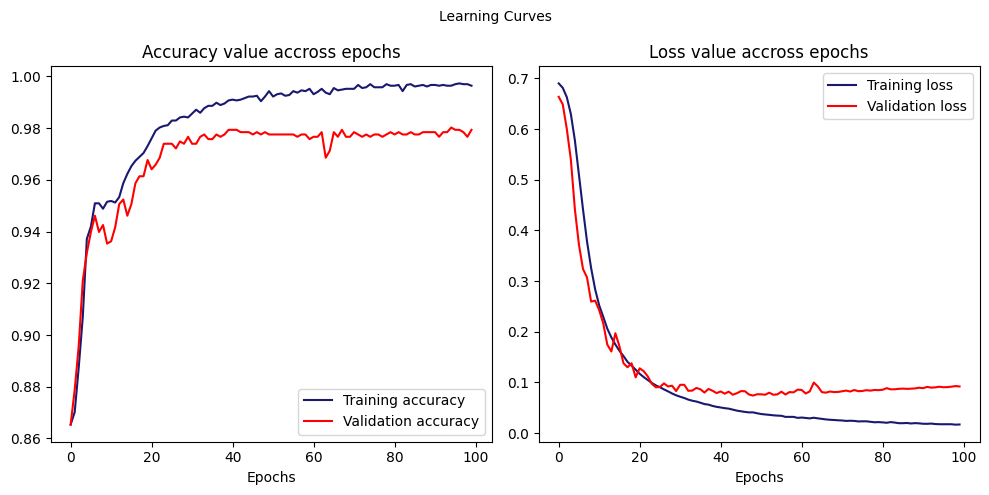

In [27]:
#Subplot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plotting accuracy on the first subplot
ax[0].plot(history.history["accuracy"], color="midnightblue",label="Training accuracy")
ax[0].plot(history.history["val_accuracy"], color="r",label="Validation accuracy")
ax[0].set_title('Accuracy value accross epochs')
ax[0].legend()

# Plotting loss on the second subplot
ax[1].plot(history.history["loss"], color="midnightblue",label="Training loss")
ax[1].plot(history.history["val_loss"], color="r",label="Validation loss")
ax[1].set_title("Loss value accross epochs")
ax[1].legend()

#Labelling axis x
for ax in ax:
    ax.set(xlabel='Epochs')

#Suptitle
fig.suptitle('Learning Curves', fontsize=10)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [28]:
# 1. Prédiction des probabilités
y_pred_proba = model_rnn.predict(X_test)

# 2. Seuil de décision
seuil = 0.5
y_pred = (y_pred_proba > seuil).astype("int32").flatten()




35/35 [==============================] - 0s 601us/step


In [29]:
# 1. Matrice de confusion
cm_rnn = confusion_matrix(y_test, y_pred)
df_cm_rnn = pd.DataFrame(cm_rnn, index=["ham", "spam"], columns=["ham", "spam"])
df_cm_rnn = df_cm_rnn.iloc[::-1]  # Pour afficher "ham" en haut

# 2. Métriques
metrics_rnn = {
    "F1-score": round(f1_score(y_test, y_pred), 3),
    "Precision": round(precision_score(y_test, y_pred), 3),
    "Recall": round(recall_score(y_test, y_pred), 3),
    "Accuracy": round(accuracy_score(y_test, y_pred), 3)
}

# 3. Subplots
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.35, 0.65],
    subplot_titles=("Matrice de Confusion (Test - RNN)", "Métriques (Test - RNN)"),
    specs=[[{"type": "heatmap"}, {"type": "table"}]]
)

# 4. Heatmap
fig.add_trace(go.Heatmap(
    z=df_cm_rnn.values,
    x=df_cm_rnn.columns,
    y=df_cm_rnn.index,
    text=df_cm_rnn.values,
    texttemplate="%{text}",
    textfont=dict(size=12),
    colorscale='Blues',
    showscale=False
), row=1, col=1)

# 5. Encadrer la heatmap
fig.add_shape(
    type="rect",
    x0=-0.5, x1=1.5,
    y0=-0.5, y1=1.5,
    line=dict(color="black", width=2),
    row=1, col=1
)

# 6. Table des métriques
fig.add_trace(go.Table(
    header=dict(values=["Métrique", "Valeur"], fill_color="lightgrey"),
    cells=dict(values=[list(metrics_rnn.keys()), list(metrics_rnn.values())])
), row=1, col=2)

# 7. Axes
fig.update_xaxes(title_text="Prédiction", row=1, col=1)
fig.update_yaxes(title_text="Réel", row=1, col=1)

# 8. Layout
fig.update_layout(  title_text="Évaluation du RNN (Keras) sur les données de test",
                    height=400,
                    width=800 )   

fig.show()


### 5- optimisation du seuil

In [30]:
# Étape 1 : Prédictions probabilistes sur le jeu de test
y_pred_proba = model_rnn.predict(X_test)


35/35 [==============================] - 0s 564us/step


In [31]:
seuils = np.arange(0.1, 0.91, 0.05)
precision_list = []
recall_list = []
f1_list = []

for seuil in seuils:
    y_pred = (y_pred_proba > seuil).astype("int32").flatten()
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)


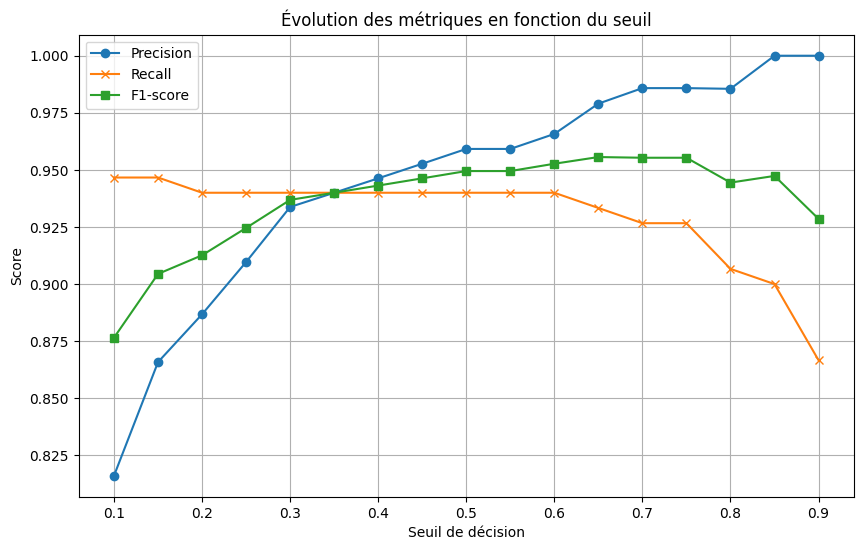

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(seuils, precision_list, label='Precision', marker='o')
plt.plot(seuils, recall_list, label='Recall', marker='x')
plt.plot(seuils, f1_list, label='F1-score', marker='s')

plt.title('Évolution des métriques en fonction du seuil')
plt.xlabel('Seuil de décision')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


In [33]:
# 1. Prédiction des probabilités
y_pred_proba = model_rnn.predict(X_test)

# 2. Seuil de décision
seuil = 0.6
y_pred = (y_pred_proba > seuil).astype("int32").flatten()

35/35 [==============================] - 0s 491us/step


In [34]:
# 1. Matrice de confusion
cm_rnn = confusion_matrix(y_test, y_pred)
df_cm_rnn = pd.DataFrame(cm_rnn, index=["ham", "spam"], columns=["ham", "spam"])
df_cm_rnn = df_cm_rnn.iloc[::-1]  # Pour afficher "ham" en haut

# 2. Métriques
metrics_rnn = {
    "F1-score": round(f1_score(y_test, y_pred), 3),
    "Precision": round(precision_score(y_test, y_pred), 3),
    "Recall": round(recall_score(y_test, y_pred), 3),
    "Accuracy": round(accuracy_score(y_test, y_pred), 3)
}

# 3. Subplots
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.35, 0.65],
    subplot_titles=("Matrice de Confusion (Test - RNN)", "Métriques (Test - RNN)"),
    specs=[[{"type": "heatmap"}, {"type": "table"}]]
)

# 4. Heatmap
fig.add_trace(go.Heatmap(
    z=df_cm_rnn.values,
    x=df_cm_rnn.columns,
    y=df_cm_rnn.index,
    text=df_cm_rnn.values,
    texttemplate="%{text}",
    textfont=dict(size=12),
    colorscale='Blues',
    showscale=False
), row=1, col=1)

# 5. Encadrer la heatmap
fig.add_shape(
    type="rect",
    x0=-0.5, x1=1.5,
    y0=-0.5, y1=1.5,
    line=dict(color="black", width=2),
    row=1, col=1
)

# 6. Table des métriques
fig.add_trace(go.Table(
    header=dict(values=["Métrique", "Valeur"], fill_color="lightgrey"),
    cells=dict(values=[list(metrics_rnn.keys()), list(metrics_rnn.values())])
), row=1, col=2)

# 7. Axes
fig.update_xaxes(title_text="Prédiction", row=1, col=1)
fig.update_yaxes(title_text="Réel", row=1, col=1)

# 8. Layout
fig.update_layout(
    title_text="Évaluation du RNN (Keras) sur les données de test",
    height=400,
    width=800
)

fig.show()


## Transfert learning with BERT

### 1- Parametrage & data

In [35]:
# 🔧 Paramètres
BATCH_SIZE = 32
NUM_WORDS = 7000
EPOCHS = 10
SEQUENCE_LENGTH = 130
PRESET = "distil_bert_base_en_uncased"
SEED = 42

In [36]:
# 💾 Préparation des données
df_bert = dataset[['spam_clean', 'spam']].copy()
df_bert = df_bert.rename(columns={'spam_clean': 'text', 'spam': 'label'})
df_bert['text'] = df_bert['text'].astype(str)

### 2- test val split

In [37]:
# Split stratifié
X_train, X_test, y_train, y_test = train_test_split(df_bert["text"], df_bert["label"],
                                                    test_size=0.2, stratify=df_bert["label"], random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.25, stratify=y_train, random_state=SEED)  # 60/20/20

### 3- Preprocessing & model

In [38]:
# Prétraitement
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(PRESET, sequence_length=SEQUENCE_LENGTH)
backbone = keras_nlp.models.DistilBertBackbone.from_preset(PRESET)

In [39]:
# 🔨 Construction du modèle 
def build_distilbert_model():
    inputs = keras.Input(shape=(), dtype=tf.string, name="text")
    x = preprocessor(inputs)
    x = backbone(x)  # shape = (batch_size, seq_len, 768)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(inputs, outputs)

model = build_distilbert_model()

In [40]:
# Compilation
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=2e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.Recall(), keras.metrics.Precision()]
)

In [47]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 distil_bert_preprocessor (Dist  {'token_ids': (None  0          ['text[0][0]']                   
 ilBertPreprocessor)            , 130),                                                           
                                 'padding_mask': (N                                               
                                one, 130)}                                                        
                                                                                                  
 distil_bert_backbone (DistilBe  (None, None, 768)   66362880    ['distil_bert_preprocessor[0]

In [41]:
# Datasets TensorFlow
def to_dataset(texts, labels):
    ds = tf.data.Dataset.from_tensor_slices((texts, labels))
    return ds.shuffle(1000, seed=SEED).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = to_dataset(X_train.to_numpy(), y_train.to_numpy())
val_ds   = to_dataset(X_val.to_numpy(), y_val.to_numpy())
test_ds  = to_dataset(X_test.to_numpy(), y_test.to_numpy())

### 5- Entrainement

In [42]:
# Entraînement
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[early_stop], verbose=1)

Epoch 1/10
105/105 [==============================] - 410s 4s/step - loss: 0.1023 - accuracy: 0.9551 - recall: 0.7679 - precision: 0.8821 - val_loss: 0.0792 - val_accuracy: 0.9776 - val_recall: 0.8867 - val_precision: 0.9433
Epoch 2/10
105/105 [==============================] - 404s 4s/step - loss: 0.0288 - accuracy: 0.9925 - recall: 0.9621 - precision: 0.9818 - val_loss: 0.0796 - val_accuracy: 0.9749 - val_recall: 0.8867 - val_precision: 0.9236
Epoch 3/10
105/105 [==============================] - 397s 4s/step - loss: 0.0178 - accuracy: 0.9952 - recall: 0.9732 - precision: 0.9909 - val_loss: 0.0635 - val_accuracy: 0.9812 - val_recall: 0.9133 - val_precision: 0.9448
Epoch 4/10
105/105 [==============================] - 397s 4s/step - loss: 0.0074 - accuracy: 0.9982 - recall: 0.9911 - precision: 0.9955 - val_loss: 0.0791 - val_accuracy: 0.9821 - val_recall: 0.9000 - val_precision: 0.9643
Epoch 5/10
105/105 [==============================] - 391s 4s/step - loss: 0.0030 - accuracy: 0.9997

### 6- Evaluation

35/35 [==============================] - 38s 1s/step - loss: 0.0509 - accuracy: 0.9883 - recall: 0.9396 - precision: 0.9722

✅ Accuracy: 0.9883 | Recall: 0.9396 | Precision: 0.9722 | Loss: 0.0509
35/35 [==============================] - 38s 1s/step

📋 Classification Report :
              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       966
        Spam       0.97      0.94      0.96       149

    accuracy                           0.99      1115
   macro avg       0.98      0.97      0.97      1115
weighted avg       0.99      0.99      0.99      1115

🎯 F1 Score : 0.9556313993174061


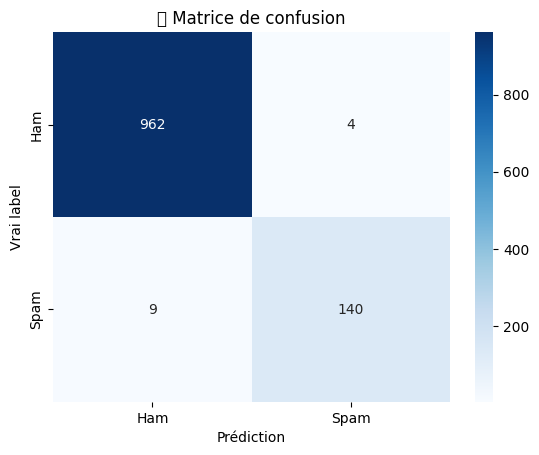

In [43]:
# 🧪 Évaluation sur test
loss, acc, recall, precision = model.evaluate(test_ds, verbose=1)
print(f"\n✅ Accuracy: {acc:.4f} | Recall: {recall:.4f} | Precision: {precision:.4f} | Loss: {loss:.4f}")

# 📊 Rapport de classification
y_pred_probs = model.predict(X_test.to_numpy())
y_pred = np.where(y_pred_probs < 0.5, 0, 1)
print("\n📋 Classification Report :")
print(classification_report(y_test, y_pred, target_names=["Ham", "Spam"]))
print("🎯 F1 Score :", f1_score(y_test, y_pred))

# 🔷 Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Prédiction")
plt.ylabel("Vrai label")
plt.title("📊 Matrice de confusion")
plt.show()



In [44]:

# ⚠️ Prédictions brutes de probas (déjà fait dans ton code plus haut)
y_proba = model.predict(X_test.to_numpy(), batch_size=BATCH_SIZE).flatten()

# 🔍 Résultats pour chaque seuil
thresholds = np.arange(0.0, 1.01, 0.1)
results = []

for thresh in thresholds:
    y_pred = (y_proba >= thresh).astype(int)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred)
    results.append((thresh, precision, recall, f1))
    print(f"🔸 Seuil = {thresh:.1f} | Recall = {recall:.3f} | Precision = {precision:.3f} | F1 = {f1:.3f}")


35/35 [==============================] - 37s 1s/step
🔸 Seuil = 0.0 | Recall = 1.000 | Precision = 0.134 | F1 = 0.236
🔸 Seuil = 0.1 | Recall = 0.966 | Precision = 0.883 | F1 = 0.923
🔸 Seuil = 0.2 | Recall = 0.946 | Precision = 0.934 | F1 = 0.940
🔸 Seuil = 0.3 | Recall = 0.946 | Precision = 0.940 | F1 = 0.943
🔸 Seuil = 0.4 | Recall = 0.946 | Precision = 0.946 | F1 = 0.946
🔸 Seuil = 0.5 | Recall = 0.940 | Precision = 0.972 | F1 = 0.956
🔸 Seuil = 0.6 | Recall = 0.940 | Precision = 0.972 | F1 = 0.956
🔸 Seuil = 0.7 | Recall = 0.940 | Precision = 0.972 | F1 = 0.956
🔸 Seuil = 0.8 | Recall = 0.933 | Precision = 0.972 | F1 = 0.952
🔸 Seuil = 0.9 | Recall = 0.919 | Precision = 0.979 | F1 = 0.948
🔸 Seuil = 1.0 | Recall = 0.000 | Precision = 0.000 | F1 = 0.000


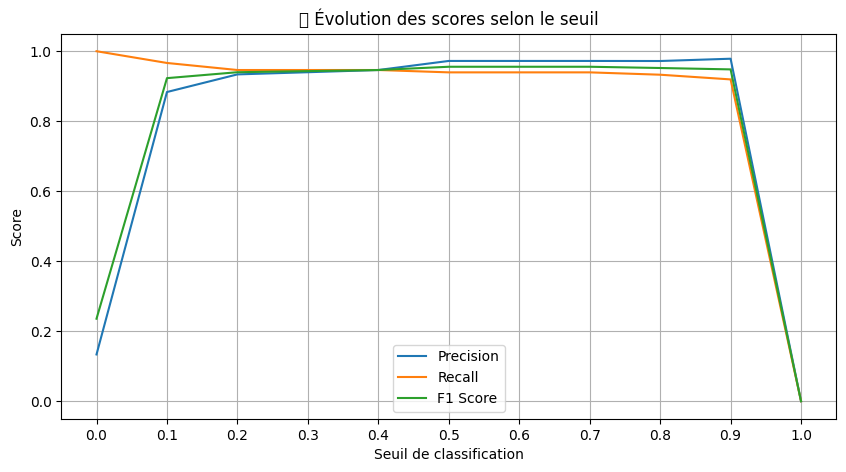

In [45]:
# 📊 Affichage des résultats
thresholds_plot, precisions, recalls, f1s = zip(*results)

plt.figure(figsize=(10, 5))
plt.plot(thresholds_plot, precisions, label="Precision")
plt.plot(thresholds_plot, recalls, label="Recall")
plt.plot(thresholds_plot, f1s, label="F1 Score")
plt.xlabel("Seuil de classification")
plt.ylabel("Score")
plt.title("🎯 Évolution des scores selon le seuil")
plt.xticks(thresholds_plot)
plt.grid(True)
plt.legend()
plt.show()


📄 Rapport de classification :
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       966
        Spam       0.91      0.96      0.93       149

    accuracy                           0.98      1115
   macro avg       0.95      0.97      0.96      1115
weighted avg       0.98      0.98      0.98      1115



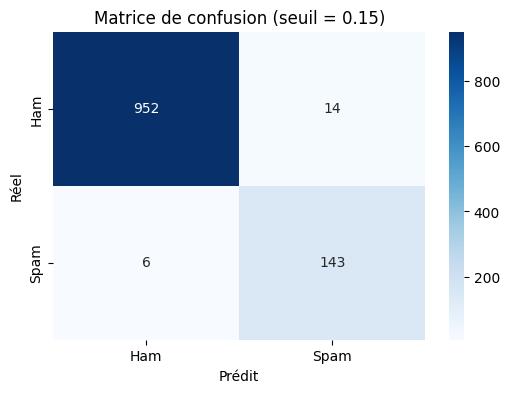

In [46]:
seuil_optimal = 0.15  

# 🎯 Prédiction avec nouveau seuil
y_pred_thresh = (y_proba >= seuil_optimal).astype(int)

# 📊 Rapport de classification
print("📄 Rapport de classification :")
print(classification_report(y_test, y_pred_thresh, target_names=["Ham", "Spam"]))

# 🔷 Matrice de confusion
cm = confusion_matrix(y_test, y_pred_thresh)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title(f"Matrice de confusion (seuil = {seuil_optimal})")
plt.show()
